In [22]:
import numpy as np
def position_1D(dimension,pos):
    assert dimension%2==0
    omega=np.arange(dimension//2,dtype=float)
    #print(omega)
    omega/=dimension/2.
    omega=1./10000**omega
    print(omega)
    pos=pos.reshape(-1)
    out=np.einsum('m,d->md',pos,omega)
    #print(out)
    Sin_out=np.sin(out)
    Cos_out=np.cos(out)
    embedding=np.concatenate([Sin_out,Cos_out],axis=1)
    return embedding
def position_2D(dimension,grid):
    embed_H=position_1D(dimension//2,grid[0])
    embed_W=position_1D(dimension//2,grid[1])
    embeding=np.concatenate([embed_H,embed_W],axis=1)
    return embeding
def get_2d_position_from_start(embed_dim,grid_size):
    grid_height=np.arange(grid_size,dtype=np.float32)
    grid_width=np.arange(grid_size,dtype=np.float32)
    grid=np.meshgrid(grid_width,grid_height)
    grid=np.stack(grid,axis=0)
    position=position_2D(embed_dim,grid)
    return position
def relative_position(embed_dim,grid_size):
    pos_embedding=get_2d_position_from_start(embed_dim,grid_size)
    relative_position=2*np.matmul(pos_embedding,pos_embedding.transpose())/pos_embedding.shape[1]
    return relative_position
import torch
from torch import nn
import math
def pairwise_distance(x):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_inner = -2*torch.matmul(x, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square + x_inner + x_square.transpose(2, 1)


def part_pairwise_distance(x, start_idx=0, end_idx=1):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_part = x[:, start_idx:end_idx]
        x_square_part = torch.sum(torch.mul(x_part, x_part), dim=-1, keepdim=True)
        x_inner = -2*torch.matmul(x_part, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square_part + x_inner + x_square.transpose(2, 1)


def xy_pairwise_distance(x, y):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        xy_inner = -2*torch.matmul(x, y.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        y_square = torch.sum(torch.mul(y, y), dim=-1, keepdim=True)
        return x_square + xy_inner + y_square.transpose(2, 1)
def dense_knn_matrix(x,k=16,relative_position=None):
    with torch.no_grad():
        x=x.transpose(2,1).squeeze(-1)
        batch_size,n_points,n_dims=x.shape
        n_part=10000

        if n_points>n_part:
            nn_idsx_list=[]
            groups=math.ceil(n_points/n_part)
            for i in range (groups):
                start_idx=n_part*i
                end_idx=min(n_points,n_part*(i+1))
                distance=part_pairwise_distance(x.detach(),start_idx,end_idx)
                if relative_position is not None:
                    distance+=relative_position[:,start_idx:end_idx]
                _,nn_idx_part=torch.topk(-distance,k=k)
                nn_idx_list+=[nn.idx_list]
            nn_idx=torch.cat(nn_idsx_list,dim=1)
        else:
            distance=pairwise_distance(x.detach())
            if relative_position is not None:
                distance+=relative_position
                _,nn_idx=torch.topk(-distance,k=k)
        center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
        return torch.stack((nn_idx,center_idx),dim=0)
def xy_dense_knn_matrix(x, y, k=16, relative_pos=None):

    with torch.no_grad():
            x = x.transpose(2, 1).squeeze(-1)
            y = y.transpose(2, 1).squeeze(-1)
            batch_size, n_points, n_dims = x.shape
            dist = xy_pairwise_distance(x.detach(), y.detach())
            if relative_pos is not None:
                dist += relative_pos
            _, nn_idx = torch.topk(-dist, k=k)
            center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
    return torch.stack((nn_idx, center_idx), dim=0)
class DenseDilated(nn.Module):
    def __init__(self,k=9,dilation=9,stochastic=False,epsilon=0.0):
        super(DenseDilated, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k
    def forward(self,edge_index):
        if self.stochastic:
            if torch.rand(1) < self.epsilon and self.training:
                num=self.k*self.dilation
                randnum=torch.randperm(num)[:self.k]
                edge_index=edge_index[:,:,:,randnum]
            else:
                edge_index=edge_index[:,:,:,::self.dilation]
        else:
            edge_index=edge_index[:,:,:,::self.dilation]
        return edge_index

class DenseDilatedKnnGraph(nn.Module):
    """
    Find the neighbors' indices based on dilated knn
    """
    def __init__(self, k=9, dilation=1, stochastic=False, epsilon=0.0):
        super(DenseDilatedKnnGraph, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k
        self._dilated = DenseDilated(k, dilation, stochastic, epsilon)

    def forward(self, x, y=None, relative_pos=None):
        if y is not None:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            y = F.normalize(y, p=2.0, dim=1)
            ####
            edge_index = xy_dense_knn_matrix(x, y, self.k * self.dilation, relative_pos)
        else:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            ####
            edge_index = dense_knn_matrix(x, self.k * self.dilation, relative_pos)
        return self._dilated(edge_index)
from torch.nn import Sequential as Seq, Linear as Lin, Conv2d
def act_layer(act, inplace=False, neg_slope=0.2, n_prelu=1):
    # activation layer

    act = act.lower()
    if act == 'relu':
        layer = nn.ReLU(inplace)
    elif act == 'leakyrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    elif act == 'gelu':
        layer = nn.GELU()
    elif act == 'hswish':
        layer = nn.Hardswish(inplace)
    else:
        raise NotImplementedError('activation layer [%s] is not found' % act)
    return layer
def norm_layer(norm, nc):
    # normalization layer 2d
    norm = norm.lower()
    if norm == 'batch':
        layer = nn.BatchNorm2d(nc, affine=True)
    elif norm == 'instance':
        layer = nn.InstanceNorm2d(nc, affine=False)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm)
    return layer
class BasicConv(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True, drop=0.):
        m = []
        for i in range(1, len(channels)):
            m.append(Conv2d(channels[i - 1], channels[i], 1, bias=bias, groups=4))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if drop > 0:
                m.append(nn.Dropout2d(drop))

        super(BasicConv, self).__init__(*m)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
def batched_index_select(x, idx):
    r"""fetches neighbors features from a given neighbor idx

    Args:
        x (Tensor): input feature Tensor
                :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times 1}`.
        idx (Tensor): edge_idx
                :math:`\mathbf{X} \in \mathbb{R}^{B \times N \times l}`.
    Returns:
        Tensor: output neighbors features
            :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times k}`.
    """
    batch_size, num_dims, num_vertices_reduced = x.shape[:3]
    _, num_vertices, k = idx.shape
    idx_base = torch.arange(0, batch_size, device=idx.device).view(-1, 1, 1) * num_vertices_reduced
    idx = idx + idx_base
    idx = idx.contiguous().view(-1)

    x = x.transpose(2, 1)
    feature = x.contiguous().view(batch_size * num_vertices_reduced, -1)[idx, :]
    feature = feature.view(batch_size, num_vertices, k, num_dims).permute(0, 3, 1, 2).contiguous()
    return feature
from torchvision.models import resnet50

class BasicConv(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True, drop=0.):
        m = []
        for i in range(1, len(channels)):
            m.append(Conv2d(channels[i - 1], channels[i], 1, bias=bias, groups=4))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if drop > 0:
                m.append(nn.Dropout2d(drop))

        super(BasicConv, self).__init__(*m)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
class Max_relative(nn.Module):

    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(Max_relative,self).__init__()
        self.conv1=BasicConv([in_channels*2,out_channels],act, norm, bias)
    def forward(self,x,edge_index,y=None):
        x_i=batched_index_select(x,edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j,_=torch.max(x_j-x_i,-1, keepdim=True)
        b, c, n, _ = x.shape
        x = torch.cat([x.unsqueeze(2), x_j.unsqueeze(2)], dim=2).reshape(b, 2 * c, n, _)
        return self.conv1(x)

class EdgeConv2d(nn.Module):
    """
    Edge convolution layer (with activation, batch normalization) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(EdgeConv2d, self).__init__()
        self.nn = BasicConv([in_channels * 2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        x_i = batched_index_select(x, edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        max_value, _ = torch.max(self.nn(torch.cat([x_i, x_j - x_i], dim=1)), -1, keepdim=True)
        return max_value


class GraphSAGE(nn.Module):
    """
    GraphSAGE Graph Convolution (Paper: https://arxiv.org/abs/1706.02216) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GraphSAGE, self).__init__()
        self.nn1 = BasicConv([in_channels, in_channels], act, norm, bias)
        self.nn2 = BasicConv([in_channels*2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j, _ = torch.max(self.nn1(x_j), -1, keepdim=True)
        return self.nn2(torch.cat([x, x_j], dim=1))


class GINConv2d(nn.Module):
    """
    GIN Graph Convolution (Paper: https://arxiv.org/abs/1810.00826) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GINConv2d, self).__init__()
        self.nn = BasicConv([in_channels, out_channels], act, norm, bias)
        eps_init = 0.0
        self.eps = nn.Parameter(torch.Tensor([eps_init]))

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j = torch.sum(x_j, -1, keepdim=True)
        return self.nn((1 + self.eps) * x + x_j)


class GraphConv2d(nn.Module):
    """
    Static graph convolution layer
    """
    def __init__(self, in_channels, out_channels, conv='edge', act='relu', norm=None, bias=True):
        super(GraphConv2d, self).__init__()
        if conv == 'edge':
            self.gconv = EdgeConv2d(in_channels, out_channels, act, norm, bias)
        elif conv == 'mr':
            self.gconv = Max_relative(in_channels, out_channels, act, norm, bias)
        elif conv == 'sage':
            self.gconv = GraphSAGE(in_channels, out_channels, act, norm, bias)
        elif conv == 'gin':
            self.gconv = GINConv2d(in_channels, out_channels, act, norm, bias)
        else:
            raise NotImplementedError('conv:{} is not supported'.format(conv))

    def forward(self, x, edge_index, y=None):
        return self.gconv(x, edge_index, y)

import torch.nn.functional as F
class Dynamic_graph(GraphConv2d):
    def __init__(self,in_channels, out_channels, kernel_size=9, dilation=1, conv='edge', act='relu',
                 norm=None, bias=True, stochastic=False, epsilon=0.0, r=1):
        super(Dynamic_graph,self).__init__(in_channels,out_channels,conv,act,norm,bias)
        self.k=kernel_size
        self.d=dilation
        self.r=r
        self.knn_graph=DenseDilatedKnnGraph(kernel_size,dilation,stochastic,epsilon)
    def forward(self,x,relative_position=None):
        B,C,H,W=x.shape
        y=None
        if self.r > 1:
            y = F.avg_pool2d(x, self.r, self.r)
            y = y.reshape(B, C, -1, 1).contiguous()
        x=x.reshape(B,C,-1,1).contiguous()
        edge_index=self.knn_graph(x,y,relative_position)
        x=super(Dynamic_graph,self).forward(x,edge_index,y)
        return x.reshape(B, -1, H, W).contiguous()
class  Grapher(nn.Module):
    def __init__(self,in_channels, kernel_size=9, dilation=1, conv='edge', act='relu', norm=None,
                 bias=True,  stochastic=False, epsilon=0.0, r=1, n=196, drop_path=0.0, relative_pos=False) :
        super(Grapher,self).__init__()
        self.channels = in_channels
        self.n = n
        self.r = r
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.graph_conv = Dynamic_graph(in_channels, in_channels * 2, kernel_size, dilation, conv,
                              act, norm, bias, stochastic, epsilon, r)
        self.fc2 = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.relative_pos = None
        if relative_pos :
            print('using relative pos')
            relative_pos_tensor=torch.from_numpy(np.float32(relative_position(in_channels,int(n**0.5)))).unsqueeze(0).unsqueeze(1)
            relative_pos_tensor = F.interpolate(
                    relative_pos_tensor, size=(n, n//(r*r)), mode='bicubic', align_corners=False)
            self.relative_pos=nn.Parameter(-relative_pos_tensor.squeeze(1),requires_grad=False)
    def _get_relative_pos(self, relative_pos, H, W):
        if relative_pos is None or H * W == self.n:
            return relative_pos
        else:
            N = H * W
            N_reduced = N // (self.r * self.r)
            return F.interpolate(relative_pos.unsqueeze(0), size=(N, N_reduced), mode="bicubic").squeeze(0)

    def forward(self, x):
        _tmp = x
        x = self.fc1(x)
        B, C, H, W = x.shape
        relative_pos = self._get_relative_pos(self.relative_pos, H, W)
        x = self.graph_conv(x, relative_pos)
        x = self.fc2(x)
        x = self.drop_path(x) + _tmp
        return x
class FFN(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act='relu', drop_path=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(hidden_features),
        )
        self.act = act_layer(act)
        self.fc2 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop_path(x) + shortcut
        return x
class Stem(nn.Module):
    def __init__(self, img_size=224, in_dim=3, out_dim=768, act='relu'):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim//2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//2),
            act_layer(act),
            nn.Conv2d(out_dim//2, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            act_layer(act),
            nn.Conv2d(out_dim, out_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.convs(x)
        return x
class Downsample(nn.Module):

    def __init__(self, in_dim=3, out_dim=768):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.conv(x)
        return x
from torch.nn import Sequential as Seq

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 6, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    'vig_224_gelu': _cfg(
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
    'vig_b_224_gelu': _cfg(
        crop_pct=0.95, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
}
class DeepGCN(torch.nn.Module):
    def __init__(self, opt):
        super(DeepGCN, self).__init__()
        print(opt)
        k = opt.k
        act = opt.act
        norm = opt.norm
        bias = opt.bias
        epsilon = opt.epsilon
        stochastic = opt.use_stochastic
        conv = opt.conv
        emb_dims = opt.emb_dims
        drop_path = opt.drop_path

        blocks = opt.blocks
        self.n_blocks=sum(blocks)
        channels = opt.channels
        reduce_ratios = [4, 2, 1, 1]
        drop_path_rate=[x.item() for x in torch.linspace(0,drop_path,self.n_blocks)]
        num_knn=[int(x.item()) for x in torch.linspace(k,k,self.n_blocks) ]
        max_dilation=49//max(num_knn)
        self.stem=Stem(out_dim=channels[0],act=act)
        self.pos_embed=nn.Parameter(torch.zeros(1,channels[0],224//4,224//4))

        HW=224 // 4 * 224 // 4
        self.backbone=nn.ModuleList([])
        idx=0
        for i in range (len(blocks)):
            if i>0:
                self.backbone.append(Downsample(channels[i-1],channels[i]))
                HW=HW//4
            for j in range (blocks[i]):
                self.backbone.append (Seq(Grapher(channels[i],num_knn[idx],min(idx//4+1,max_dilation),conv, act, norm,
                                    bias, stochastic, epsilon, reduce_ratios[i], n=HW, drop_path=drop_path_rate[idx],
                                    relative_pos=True),
                          FFN(channels[i], channels[i] * 4, act=act, drop_path=drop_path_rate[idx])
                         ))
                idx+=1

        self.backbone = Seq(*self.backbone)


        self.prediction = Seq(nn.Conv2d(channels[-1], 1024, 1, bias=True),
                              nn.BatchNorm2d(1024),
                              act_layer(act),
                              nn.Dropout(opt.dropout),
                              nn.Conv2d(1024, opt.n_classes, 1, bias=True))
        self.model_init()
    def model_init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True
    def forward(self,inputs):
        x=self.stem(inputs)+self.pos_embed
        B, C, H, W = x.shape
        for i in range(len(self.backbone)):
            x = self.backbone[i](x)

        x = F.adaptive_avg_pool2d(x, 1)
        return self.prediction(x).squeeze(-1).squeeze(-1)
@register_model
def pvig_ti_224_gelu(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=6, drop_path_rate=0.3, **kwargs):
                self.k = 9 # neighbor num (default:9)
                self.conv = 'mr' # graph conv layer {edge, mr}
                self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
                self.norm = 'batch' # batch or instance normalization {batch, instance}
                self.bias = True # bias of conv layer True or False
                self.dropout = 0.3# dropout rate
                self.use_dilation = True # use dilated knn or not
                self.epsilon = 0.2 # stochastic epsilon for gcn
                self.use_stochastic = False # stochastic for gcn, True or False
                self.drop_path = drop_path_rate
                self.blocks = [2,2,6,2] # number of basic blocks in the backbone
                self.channels = [80, 160, 400, 640]  # number of channels of deep features
                self.n_classes = num_classes # Dimension of out_channels
                self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model
import gc
gc.collect()

torch.cuda.empty_cache()


In [33]:
from typing import Any, Tuple
import numpy as np
import os
import torch
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import xml.etree.ElementTree as ElementTree

class Split(datasets.ImageFolder):
     def __init__(self, root, xml_list, transform=None, target_transform=None, loader=datasets.folder.default_loader):
        super(Split, self).__init__(root, transform, target_transform, loader)
        self.file_list={}
        self.num_classes=6
        for file_name in xml_list:
            last_dot_idx = file_name.rfind('.')
            f_name_idx = file_name.rfind('/')
            root_path = file_name[f_name_idx + 1: last_dot_idx]
            tree=ElementTree.parse(file_name)
            root=tree.getroot()
            for defect in root:
                crop_name=list(defect.attrib.values())[0]
                target = self.multi_target(defect)
                self.file_list[os.path.join(root_path, crop_name)] = target
     def __getitem__(self, index): 
         image_batch=super(Split,self).__getitem__(index)[0]
         image_name = self.imgs[index][0]
         f_name_idx = image_name.rfind('/')
         f_dir_idx = image_name[: f_name_idx].rfind('/')
         de_lim = image_name.rfind('_-_')
         file_type = image_name.rfind('.')
         if de_lim != -1:
            name = image_name[f_dir_idx + 1: de_lim] + image_name[file_type:]
         else:
            name = image_name[f_dir_idx + 1:]
         return [image_batch, self.file_list[name]]
     def get_class_names(self, xml_list):
        class_names = []
        for file_name in xml_list:
            tree = ElementTree.parse(file_name)
            root = tree.getroot()
            for defect in root:
                class_name = list(defect.attrib.keys())[0]
                class_names.append(class_name)
        return class_names
     def multi_target(self,defect):
        out = np.zeros(self.num_classes, dtype=np.float32)
        for i in range(self.num_classes):
            if defect[i].text=='1':
                out[i]=1.0
        return out

class CODEBRIM:
    """
    definition of CODEBRIM dataset, train/val/test splits, train/val/test loaders

    Parameters:
        args (argparse.Namespace): parsed command line arguments
        is_gpu (bool): if computational device is gpu or cpu

    Attributes:
        num_classes (int): number of classes in the dataset (= 6)
        dataset_path (string): path to dataset folder
        dataset_xml_list (list): list to dataset meta-data
        train_set (CODEBRIMSplit): train split
        val_set (CODEBRIMSplit): validation split
        test_set (CODEBRIMSplit): test split
        train_loader (torch.utils.data.DataLoader): data-loader for train-split
        val_loader (torch.utils.data.DataLoader): data-loader for val-split
        test_loader (torch.utils.data.DataLoader): data-loader for test-split
    """
    def __init__(self, is_gpu, args):
        self.num_classes = 6
        self.dataset_path = args.dataset_path
        self.dataset_xml_list = [os.path.join(args.dataset_path, 'metadata/defects.xml'),
                                 os.path.join(args.dataset_path, 'metadata/background.xml')]
        self.train_set, self.val_set, self.test_set = self.get_dataset(args.patch_size)
        self.train_loader, self.val_loader, self.test_loader = self.get_dataset_loader(args.batch_size, args.workers,
                                                                                       is_gpu)

    def get_dataset(self, patch_size):
        """
        return dataset splits

        Parameters:
            patch_size (int): patch-size to rescale the images to
        
        Returns:
            train_set, val_set, test_set of type lib.Datasets.datasets.CODEBRIMSplit
        """
        train_set =Split(os.path.join(self.dataset_path, 'train'),
                                  self.dataset_xml_list,
                                  transform=transforms.Compose([transforms.Resize(patch_size),
                                                               transforms.RandomCrop(patch_size),
                                                               transforms.RandomHorizontalFlip(),
                                                               transforms.ToTensor()]))
        val_set =Split(os.path.join(self.dataset_path, 'val'),
                                self.dataset_xml_list,
                                transform=transforms.Compose([transforms.Resize(patch_size),
                                                             transforms.CenterCrop(patch_size),
                                                             transforms.ToTensor()]))
        test_set =Split(os.path.join(self.dataset_path, 'test'),
                                 self.dataset_xml_list,
                                 transform=transforms.Compose([transforms.Resize(patch_size),
                                                              transforms.CenterCrop(patch_size),
                                                              transforms.ToTensor()]))
        return train_set, val_set, test_set

    def get_dataset_loader(self, batch_size, workers, is_gpu):
        """
        defines the dataset loader for wrapped dataset

        Parameters:
            batch_size (int): mini batch size in data loader
            workers (int): number of parallel cpu threads for data loading
            is_gpu (bool): True if CUDA is enabled so pin_memory is set to True
        
        Returns:
            train_loader, val_loader, test_loader of type torch.utils.data.DataLoader
        """
        train_loader = torch.utils.data.DataLoader(self.train_set, num_workers=workers, batch_size=batch_size,
                                                   shuffle=True, pin_memory=is_gpu)
        val_loader = torch.utils.data.DataLoader(self.val_set, num_workers=workers, batch_size=batch_size,
                                                 shuffle=False,pin_memory=is_gpu)
        test_loader = torch.utils.data.DataLoader(self.test_set, num_workers=workers, batch_size=batch_size,
                                                  shuffle=False, pin_memory=is_gpu)

        return train_loader, val_loader, test_loader

In [36]:
xml_list = [os.path.join(args.dataset_path, 'metadata/defects.xml'),
                                 os.path.join(args.dataset_path, 'metadata/background.xml')]

split_instance = Split(root="/home/accl-ros/Downloads/classification_dataset/train", xml_list=xml_list)
class_names = split_instance.get_class_names(xml_list)
print("Class Names:", class_names)

Class Names: ['name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'name', 'n

In [42]:
label_dict = {
    "Background": 0,
    "Crack": 1,
    "Spallation": 2,
    "Efflorescence": 3,
    "ExposedBars": 4,
    "CorrosionStain": 5
}

In [44]:
import argparse
import os
# Create a simple argparse.Namespace object to mimic command line arguments
class ArgsNamespace:
    def __init__(self, dataset_path, patch_size, batch_size, workers):
        self.dataset_path = dataset_path
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.workers = workers

# Create an instance of ArgsNamespace with appropriate values
args = ArgsNamespace(
    dataset_path="/home/accl-ros/Downloads/classification_dataset",
    patch_size=224,
    batch_size=32,
    workers=4
)

# Assuming CUDA is available and you want to run on GPU
is_gpu = True

# Create an instance of CODEBRIM with the provided arguments
codebrim_instance = CODEBRIM(is_gpu, args)

# Access attributes and methods for testing
print("Number of classes:", codebrim_instance.num_classes)
print("Dataset path:", codebrim_instance.dataset_path)
print("Dataset XML list:", codebrim_instance.dataset_xml_list)


train_set, val_set, test_set = codebrim_instance.train_set, codebrim_instance.val_set, codebrim_instance.test_set

train_loader, val_loader, test_loader = codebrim_instance.train_loader, codebrim_instance.val_loader, codebrim_instance.test_loader

# Print some information about the datasets and loaders
print("Train Set Length:", len(train_set))
print("Validation Set Length:", len(val_set))
print("Test Set Length:", len(test_set))


for batch_idx, (inputs, targets) in enumerate(val_loader):
    print(f"Batch {batch_idx + 1}: Input Shape - {inputs.shape}, Target Shape - {targets.shape}")



Number of classes: 6
Dataset path: /home/accl-ros/Downloads/classification_dataset
Dataset XML list: ['/home/accl-ros/Downloads/classification_dataset/metadata/defects.xml', '/home/accl-ros/Downloads/classification_dataset/metadata/background.xml']
Train Set Length: 1631
Validation Set Length: 120
Test Set Length: 184
Batch 1: Input Shape - torch.Size([32, 3, 224, 224]), Target Shape - torch.Size([32, 6])
Batch 2: Input Shape - torch.Size([32, 3, 224, 224]), Target Shape - torch.Size([32, 6])
Batch 3: Input Shape - torch.Size([32, 3, 224, 224]), Target Shape - torch.Size([32, 6])
Batch 4: Input Shape - torch.Size([24, 3, 224, 224]), Target Shape - torch.Size([24, 6])


Batch 1: Input Shape - torch.Size([32, 3, 224, 224]), Target Shape - torch.Size([32, 6])


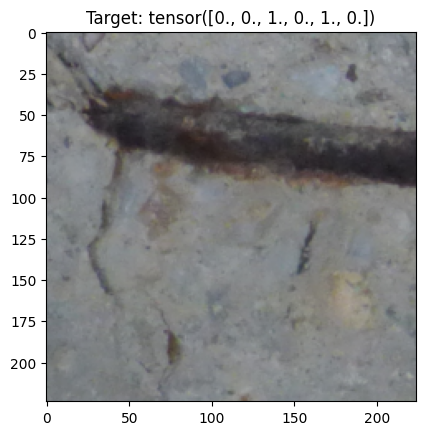

In [54]:
import matplotlib.pyplot as plt
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}: Input Shape - {inputs.shape}, Target Shape - {targets.shape}")

    # Assuming inputs is a batch of images (adjust accordingly based on your data structure)
    # Plot the first image in the batch
    plt.imshow(inputs[0].permute(1, 2, 0).cpu().numpy())  # Assuming channels-last format
    plt.title(f"Target: {targets[0]}")
    plt.show()

    # Break after the first batch for brevity
    break

Batch 1: Input Shape - torch.Size([32, 3, 224, 224]), Target Shape - torch.Size([32, 6])
['Crack', 'Background', 'Background', 'Background', 'Background', 'Background']
['Background', 'Crack', 'Background', 'Background', 'Background', 'Background']
['Background', 'Background', 'Background', 'Background', 'Crack', 'Crack']


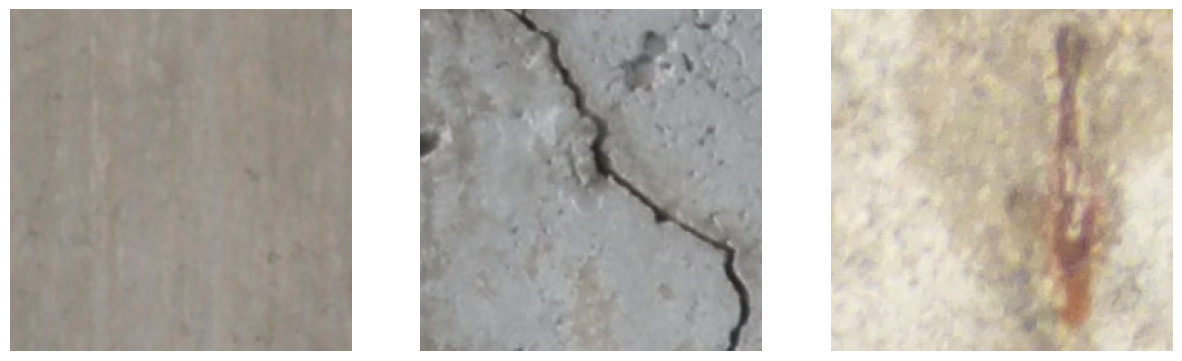

In [70]:
import matplotlib.pyplot as plt

# Assuming you have a label_dict like {0: 'class1', 1: 'class2', ...}
label_dict = {
    0: 'Background',
    1: 'Crack',
    2: 'Spallation',
    3: 'Efflorescence',
    4: 'ExposedBars',
    5: 'CorrosionStain'
}
import matplotlib.pyplot as plt

# Assuming you have a label_dict like {0: 'class1', 1: 'class2', ...}


# Assuming train_loader provides batches of images and multilabel targets
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}: Input Shape - {inputs.shape}, Target Shape - {targets.shape}")

    # Create a subplot with 1 row and 3 columns
    plt.figure(figsize=(15, 5))  # Adjust the figure size as needed
    for i in range(3):  # Assuming you want to display 3 images
        plt.subplot(1, 3, i + 1)
        plt.imshow(inputs[i].permute(1, 2, 0).cpu().numpy())  # Assuming channels-last format

        # Assuming targets is a multi-label tensor, iterate over its elements
        target_labels = [label_dict[label.item()] for label in targets[i] if label.item() in label_dict]
        print(target_labels)
        #plt.title(f"Targets: {', 'target_labels}")  # Display multiple target labels
        plt.axis('off')  # Turn off axis

    plt.show()

    # Break after the first batch for brevity
    break



Batch 1: Input Shape - torch.Size([32, 3, 224, 224]), Target Shape - torch.Size([32, 6])
tensor([1., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 1., 0., 1.])
tensor([0., 1., 0., 0., 0., 0.])


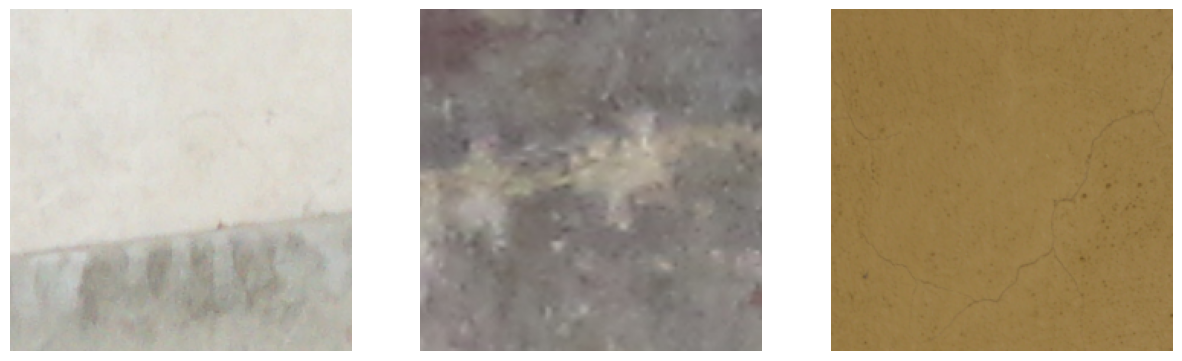

In [78]:
import matplotlib.pyplot as plt

# Assuming you have a label_dict like {0: 'class1', 1: 'class2', ...}
label_dict = {
    0: 'Background',
    1: 'Crack',
    2: 'Spallation',
    3: 'Efflorescence',
    4: 'ExposedBars',
    5: 'CorrosionStain'
}

# Assuming train_loader provides batches of images and multilabel targets
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}: Input Shape - {inputs.shape}, Target Shape - {targets.shape}")

    # Create a subplot with 1 row and 3 columns
    plt.figure(figsize=(15, 5))  # Adjust the figure size as needed
    for i in range(3):  # Assuming you want to display 3 images
        plt.subplot(1, 3, i + 1)
        plt.imshow(inputs[i].permute(1, 2, 0).cpu().numpy())  # Assuming channels-last format

        # Assuming targets is a multi-label tensor, iterate over its elements
        target_labels = [label_dict[label.item()] for label in targets[i] if label.item() in label_dict]
        print(targets[i])
        #plt.title(}")  # Display multiple target labels
        plt.axis('off')  # Turn off axis

    plt.show()

    # Break after the first batch for brevity
    break


In [46]:
sample_batch = next(iter(codebrim_instance.train_loader))

# Extract images and labels
images, labels = sample_batch

# Convert tensor labels to numpy array
labels_numpy = labels.numpy()

# Create a DataFrame for analysis
df = pd.DataFrame(labels_numpy, columns=[f'Class_{i}' for i in range(codebrim_instance.num_classes)])
df.columns = df.columns.map(lambda col: label_dict[int(col.split('_')[1])])

# Plot class distribution
class_distribution = df.sum().sort_values(ascending=False)
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in CODEBRIM Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualize some sample images
num_samples = min(5, len(images))
fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axs[i].imshow(images[i].permute(1, 2, 0))  # Assuming images are in (C, H, W) format
    axs[i].set_title(f'Sample {i + 1}\nClass: {labels[i]}')
    axs[i].axis('off')
plt.show()


KeyError: 0

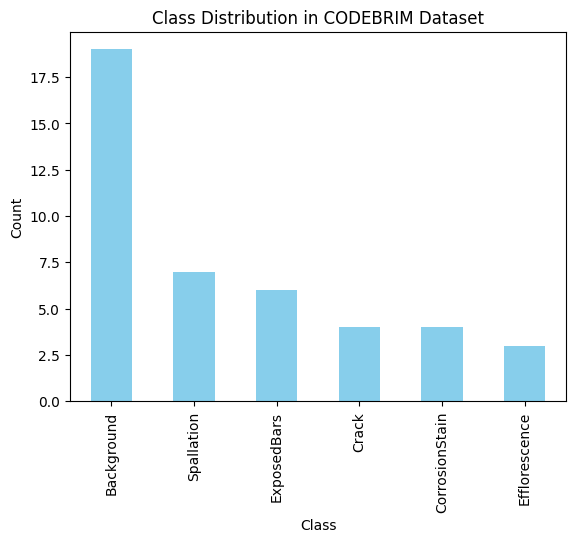

ValueError: only one element tensors can be converted to Python scalars

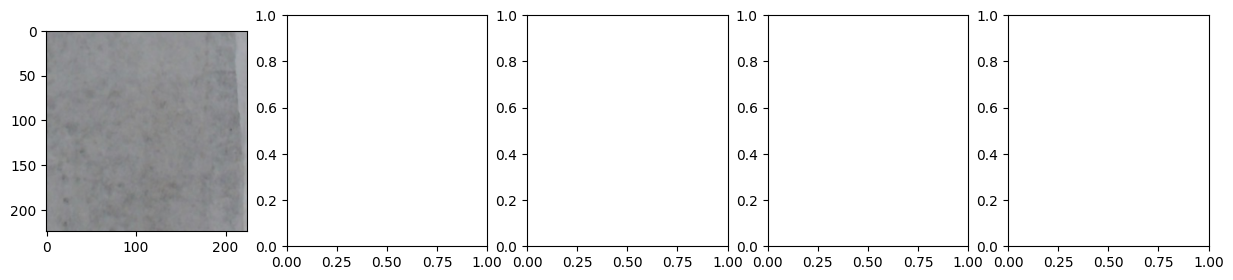

In [ ]:
# Assuming label_dict is a dictionary mapping numerical labels to class names
label_dict = {
    0: 'Background',
    1: 'Crack',
    2: 'Spallation',
    3: 'Efflorescence',
    4: 'ExposedBars',
    5: 'CorrosionStain'
}

# Replace numerical labels with class names in the DataFrame
df.columns = [label_dict[int(col.split('_')[1])] for col in df.columns]

# Plot class distribution
class_distribution = df.sum().sort_values(ascending=False)
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in CODEBRIM Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualize some sample images
num_samples = min(5, len(images))
fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axs[i].imshow(images[i].permute(1, 2, 0))  # Assuming images are in (C, H, W) format
    axs[i].set_title(f'Sample {i + 1}\nClass: {label_dict[int(labels[i])]}')
    axs[i].axis('off')
plt.show()



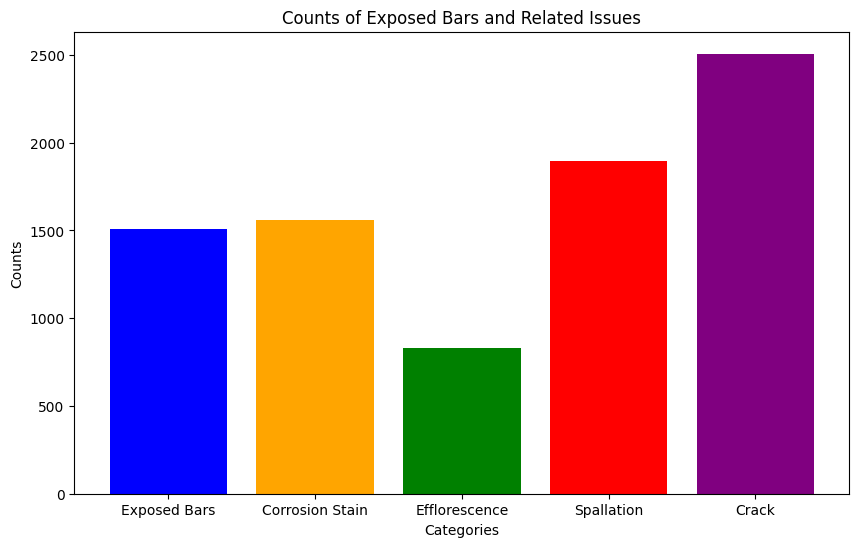

In [47]:
import matplotlib.pyplot as plt

# Data
categories = ['Exposed Bars', 'Corrosion Stain', 'Efflorescence', 'Spallation', 'Crack']
counts = [1507, 1559, 833, 1898, 2507]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts of Exposed Bars and Related Issues')
plt.show()




In [26]:
for batch_idx, (inputs, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1}: Target Values - {targets}")

    # Optionally, you can also print input shapes or other information
    # print(f"Input Shapes - {inputs.shape}")

    # Break after the first few batches for brevity
    if batch_idx == 2:
        break

Batch 1: Target Values - tensor([[0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1.

In [15]:
def _save_checkpoint(self, epoch):
    ckp = self.model.module.state_dict()
    PATH = "checkpoint.pt"
    torch.save(ckp, PATH)
    print(f"Epoch {epoch} | Training checkpoint saved at {PATH}")

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings('ignore')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#

#
from torch.optim.lr_scheduler import StepLR

# Assuming you have defined a learning rate scheduler


model = pvig_ti_224_gelu(num_classes=6).to(device)
if torch.cuda.device_count() > 1:
  model = nn.DataParallel(model)


ccriterion_bce = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-3)

from torch.optim.lr_scheduler import StepLR

# Assuming you have defined a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
 factor=0.5,patience=0,
 threshold = 0.001,
 verbose=True,
 min_lr = 1e-5,
 threshold_mode = 'abs')

import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
sigmoid = nn.Sigmoid()

for epoch in range(400):

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    patience=10
    stop_count = 0
    min_valid_loss = float('inf')
    model.train()

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)


        optimizer.zero_grad()


        outputs = model(inputs)
        predicted = sigmoid(outputs) > 0.5
        correct_predictions += (predicted == labels.byte()).all(dim=1).sum().item()  # check correct predictions per sample
        total_predictions += labels.size(0)
        l1_regularization = 0
        for param in model.parameters():
            l1_regularization += torch.norm(param,1)
            loss = loss = ccriterion_bce(outputs, labels)+0.0001*l1_regularization
        loss = ccriterion_bce(outputs, labels)
        loss.backward()
        optimizer.step()
        del inputs,labels, outputs
        torch.cuda.empty_cache()

        # print statistics
        running_loss += loss.item()
        if i % 25== 24:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Training_Accuracy: {epoch_accuracy}%')
    model.eval()
    valid_loss = 0.0
    correct_predictions_test= 0
    total_predictions_test= 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            validation_loss=ccriterion_bce(outputs,labels)
            correct_predictions_test+= (predicted == labels.byte()).all(dim=1).sum().item()
            total_predictions_test += labels.size(0)

    accuracy_test = 100 * correct_predictions_test/ total_predictions_test
    print('Epoch [{}/{}], Testing_Accuracy: {:.4f}'.format(epoch+1, 500, accuracy_test))

    # Check for Early Stopping
    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        stop_count = 0
    else:
        stop_count += 1
        if stop_count >= patience:
            print("Early stopping")
            break

print('Finished Training')
torch.save({
    'model_state_dict': model.module.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_checkpoint_civil_test1.pth')


# Now let's plot the training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, 'r-', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, 'g-', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(accuracy_test, 'b-', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

<__main__.pvig_ti_224_gelu.<locals>.OptInit object at 0x7f209e630580>
using relative pos
[1.00000000e+00 6.30957344e-01 3.98107171e-01 2.51188643e-01
 1.58489319e-01 1.00000000e-01 6.30957344e-02 3.98107171e-02
 2.51188643e-02 1.58489319e-02 1.00000000e-02 6.30957344e-03
 3.98107171e-03 2.51188643e-03 1.58489319e-03 1.00000000e-03
 6.30957344e-04 3.98107171e-04 2.51188643e-04 1.58489319e-04]
[1.00000000e+00 6.30957344e-01 3.98107171e-01 2.51188643e-01
 1.58489319e-01 1.00000000e-01 6.30957344e-02 3.98107171e-02
 2.51188643e-02 1.58489319e-02 1.00000000e-02 6.30957344e-03
 3.98107171e-03 2.51188643e-03 1.58489319e-03 1.00000000e-03
 6.30957344e-04 3.98107171e-04 2.51188643e-04 1.58489319e-04]
using relative pos
[1.00000000e+00 6.30957344e-01 3.98107171e-01 2.51188643e-01
 1.58489319e-01 1.00000000e-01 6.30957344e-02 3.98107171e-02
 2.51188643e-02 1.58489319e-02 1.00000000e-02 6.30957344e-03
 3.98107171e-03 2.51188643e-03 1.58489319e-03 1.00000000e-03
 6.30957344e-04 3.98107171e-04 2.511

KeyboardInterrupt: 

In [81]:
from torchsummary import summary
summary(model, input_size=(3, 64, 64), device=str(device))

# Calculate the total number of parameters and layers
total_parameters = sum(p.numel() for p in model.parameters())
total_layers = len(list(model.children()))

print(f"Total Parameters: {total_parameters}")
print(f"Total Layers: {total_layers}")

Layer (type:depth-idx)                   Param #
├─DeepGCN: 1-1                           --
|    └─Stem: 2-1                         --
|    |    └─Sequential: 3-1              88,080
|    └─Sequential: 2-2                   --
|    |    └─Sequential: 3-2              (693,616)
|    |    └─Sequential: 3-3              (693,616)
|    |    └─Downsample: 3-4              115,680
|    |    └─Sequential: 3-5              (465,184)
|    |    └─Sequential: 3-6              (465,184)
|    |    └─Downsample: 3-7              577,200
|    |    └─Sequential: 3-8              (1,969,216)
|    |    └─Sequential: 3-9              (1,969,216)
|    |    └─Sequential: 3-10             (1,969,216)
|    |    └─Sequential: 3-11             (1,969,216)
|    |    └─Sequential: 3-12             (1,969,216)
|    |    └─Sequential: 3-13             (1,969,216)
|    |    └─Downsample: 3-14             2,305,920
|    |    └─Sequential: 3-15             (4,934,881)
|    |    └─Sequential: 3-16             (4,934

In [ ]:
model.eval()
valid_loss = 0.0
correct_predictions_test= 0
total_predictions_test= 0

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        correct_predictions_test+= (predicted == labels.byte()).all(dim=1).sum().item()
        total_predictions_test += labels.size(0)

accuracy_test = 100 * correct_predictions_test/ total_predictions_test
print('Epoch [{}/{}], Testing_Accuracy: {:.4f}'.format(epoch+1, 500, accuracy_test))

Epoch [9/500], Testing_Accuracy: 20.0000


In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming CODEBRIM class is already defined

# Create an instance of the CODEBRIM class
is_gpu = False  # Set to True if using GPU
 # Specify your arguments or create an argparse.Namespace object
codebrim_dataset = (is_gpu, args)
args = ArgsNamespace(
    dataset_path="/home/accl-ros/Downloads/classification_dataset",
    patch_size=224,
    batch_size=32,
    workers=4
)
# Get a sample batch from the training DataLoader
sample_batch = next(iter(codebrim_dataset.train_loader))

# Extract images and labels
images, labels = sample_batch

# Convert tensor labels to numpy array
labels_numpy = labels.numpy()

# Create a DataFrame for analysis
df = pd.DataFrame(labels_numpy, columns=[f'Class_{i}' for i in range(codebrim_dataset.num_classes)])

# Plot class distribution
class_distribution = df.sum().sort_values(ascending=False)
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in CODEBRIM Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualize some sample images
num_samples = min(5, len(images))
fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axs[i].imshow(images[i].permute(1, 2, 0))  # Assuming images are in (C, H, W) format
    axs[i].set_title(f'Sample {i + 1}\nClass: {labels[i]}')
    axs[i].axis('off')
plt.show()


AttributeError: 'ellipsis' object has no attribute 'dataset_path'